<a href="https://colab.research.google.com/github/Khislatz/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Khislat_Zhuraeva_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
%matplotlib inline
import category_encoders as ce 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val  =  train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train.shape, val.shape, test.shape 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


((45042, 41), (14358, 41), (14358, 40))

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        

In [0]:
X_train = wrangle(train)
X_test = wrangle(test)
X_val = wrangle(val)



In [0]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


In [7]:
# Make pipeline!

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

# Fit on train, score on val

pipeline = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print(f'Validation accuracy {accuracy_score(y_pred, y_val)}')

Validation accuracy 0.8106978687839532


#Confusion Matrix 

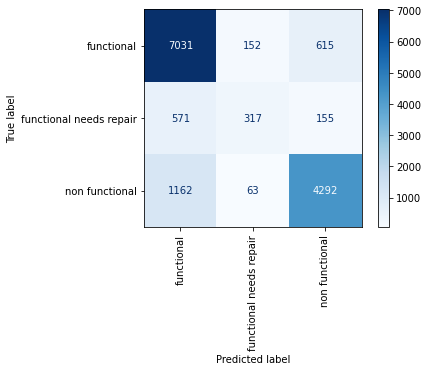

In [8]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val,
                      xticks_rotation = 'vertical',
                      values_format = '.0f',
                      cmap='Blues');


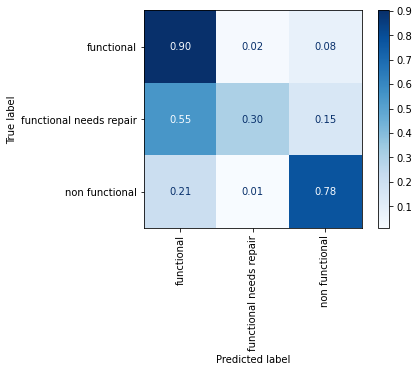

In [9]:
plot_confusion_matrix(pipeline, X_val, y_val,
                      xticks_rotation = 'vertical',
                      normalize = 'true',
                      values_format='.2f',
                      cmap='Blues');

#first row, first column  = 7031 / (7031 + 152 + 615) = 0.90
#first row, second column = 152 / (7031 + 152 + 615) = 0.019 or 0.02 etc.      

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[7031,  152,  615],
       [ 571,  317,  155],
       [1162,   63, 4292]])

In [11]:
normalized_cm = cm/cm.sum(axis=1)[:, np.newaxis] #axis=1 is rows
normalized_cm

array([[0.90164145, 0.01949218, 0.07886638],
       [0.54745925, 0.30393097, 0.14860978],
       [0.21062171, 0.01141925, 0.77795904]])

In [12]:
cm.sum(axis=1)[:, np.newaxis] # np.newaxis converted sums from row to column; np.newaxis adds a new dimension 
# first row 7031+152+615 = 7798
#second row 571+317+155 = 1043
#third row 1162+63+4292 = 5517

array([[7798],
       [1043],
       [5517]])

In [13]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val) #similar to y_val.unique but unique_labels returns in the CORRECT ORDER: functional - class 1; functional neeeds repair - class 2;
#non funtional - class 3

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [14]:
y_val.unique() #in a random order

array(['non functional', 'functional', 'functional needs repair'],
      dtype=object)

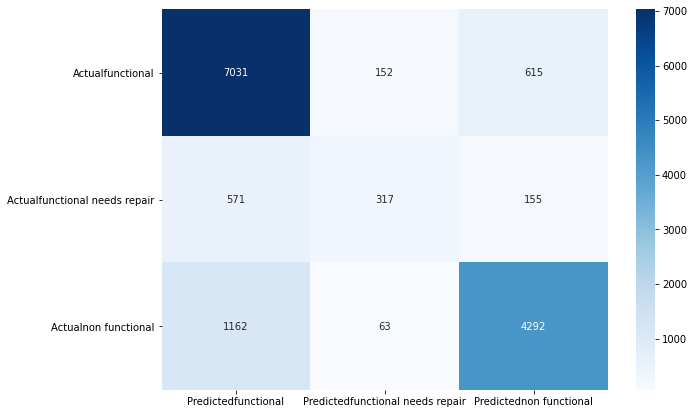

In [15]:
cols = unique_labels(y_val)
df_cm =pd.DataFrame(cm, 
                    columns=['Predicted' + col for col in cols],
                    index=['Actual' + col for col in cols])
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.0f'); 
# annot = True - lables/sets the vertical and horizontal axis according to columns and rows


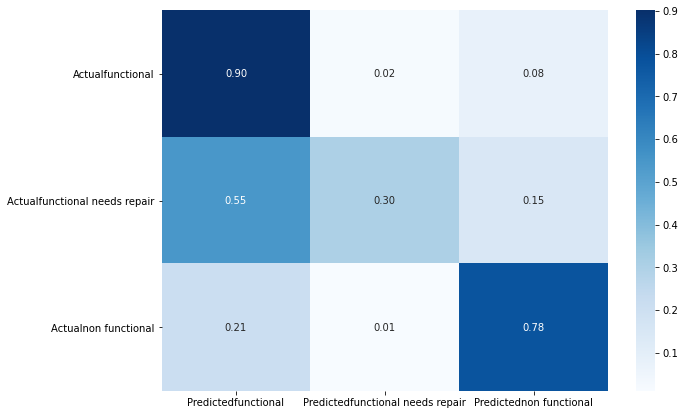

In [16]:
cols = unique_labels(y_val)
df_cm =pd.DataFrame(normalized_cm, columns=['Predicted' + col for col in cols],
                    index=['Actual' + col for col in cols])
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f'); 
# annot = True - lables/sets the vertical and horizontal axis according to columns and rows

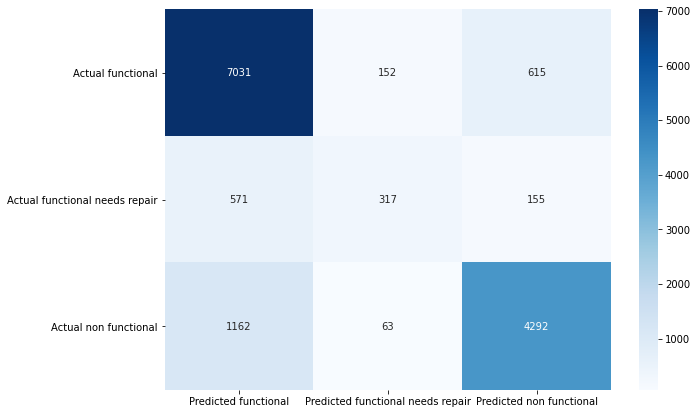

In [17]:
def plot_cm(y_val, y_pred, normalize=False):
  cols = unique_labels(y_val)
  cm = confusion_matrix(y_val, y_pred)
  if normalize:
    cm/cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f'
  else:
    fmt='.0f'
  df_cm =pd.DataFrame(cm, 
                      columns=['Predicted ' + str(col) for col in cols],
                    index=['Actual ' + str(col) for col in cols])
  plt.figure(figsize=(10,7))
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt)

plot_cm(y_val, y_pred) 

In [18]:
#How many correct predictions were made?
7031 + 317 + 4192

11540

In [19]:
#How many total predictions were made?
len(y_val)
#OR
cm.sum()

14358

In [20]:
#What was the classification accuracy?
11540 / 14358

0.803733110461067

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))
#we pass true labels - y_val and predicted y_pred


                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.60      0.30      0.40      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.66      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



In [22]:
y_pred_baseline = ['functional'] *len(y_pred)
y_pred_baseline

['functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'function

In [23]:
print(classification_report(y_val, y_pred_baseline)) #f1 is a test accuracy 

                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      7798
functional needs repair       0.00      0.00      0.00      1043
         non functional       0.00      0.00      0.00      5517

               accuracy                           0.54     14358
              macro avg       0.18      0.33      0.23     14358
           weighted avg       0.29      0.54      0.38     14358



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#recall = ratio of correctly identified observations / total 
#precision = ratio of correctly identified observations / how many classified/identified as dogs  


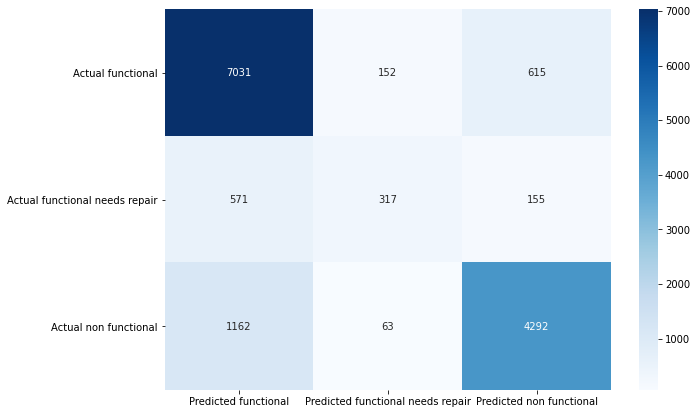

In [24]:
plot_cm(y_val, y_pred)

In [0]:
#How many correct predictions of "non-functional"?

correct_pred_non_func = 4292

In [26]:
#How many total predictions of non-functional?
total_pred_non_func = 615+155+4292
total_pred_non_func

5062

In [27]:
#what's the precision of non-functional?

precision_non_func = correct_pred_non_func / total_pred_non_func
precision_non_func

0.8478862109838009

In [28]:
print(classification_report(y_val, y_pred)) #precision score matches

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.60      0.30      0.40      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.66      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



In [0]:
#How many actual non functional waterpumps?
actual_non_func = 1162+63+4292

In [30]:
#What's the recall for non functional?
recall_non_func = correct_pred_non_func / actual_non_func
recall_non_func

0.7779590357078122

In [31]:
#what's f1 score?

# f1 = 2 * ((precision * recall) / (precision + recall))

f1_non_func = 2*((precision_non_func * recall_non_func)/((precision_non_func + recall_non_func)))
f1_non_func

0.8114188486624444

In [32]:
#If we normalize our data, we will see that only about 46% of the waterpumps would need repairs, and 54% would not need repairs.
#So we would waste our resouces if we send maintenance crew to check our functional waterpumps
#That's why we will turn from classification to binary
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [45]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

# turn from classification to binary. So we could filter only the ones that need repair and non functional, which are categorized as True 

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


True    1.0
Name: status_group, dtype: float64

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)


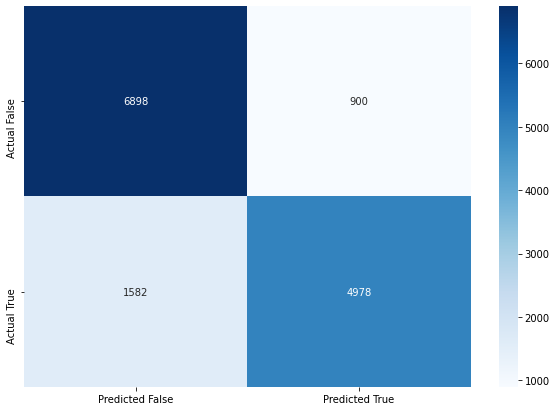

In [35]:
plot_cm(y_val, y_pred)

In [36]:
y_pred.sum() #We don't have "budget" to Take an action on all these predictions
#we only have budget for 2000 so we need to prioritize the ones with the highest probability 

5878

In [37]:
pipeline.predict_proba(X_val) # returns a 2 dimensional array, each row sums up to 1 



array([[0.  , 1.  ],
       [0.3 , 0.7 ],
       [0.89, 0.11],
       ...,
       [0.86, 0.14],
       [0.59, 0.41],
       [0.97, 0.03]])

In [38]:
pipeline.predict(X_val) 

array([ True,  True, False, ..., False, False, False])

In [39]:
#to extract the second columns and 1 row we can 
pipeline.predict_proba(X_val)[:,1]

array([1.  , 0.7 , 0.11, ..., 0.14, 0.41, 0.03])

In [40]:
#We set a threshold 0.5
pipeline.predict_proba(X_val)[:,1] > 0.5

# we pick only probabilities greater than 50%

array([ True,  True, False, ..., False, False, False])

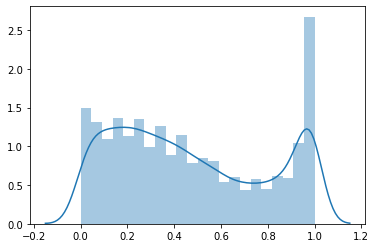

In [41]:
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
sns.distplot(y_pred_proba);

False    12293
True      2065
dtype: int64

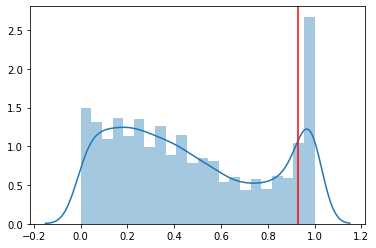

In [42]:
#Change the threshold to 0.6, 0.7, 0.9, etc
#Takes approximately 93% threshhold to meet the budget $2000
thres = 0.93

y_pred = y_pred_proba > thres 

ax = sns.distplot(y_pred_proba)
ax.axvline(thres, color='red') 
pd.Series(y_pred).value_counts()


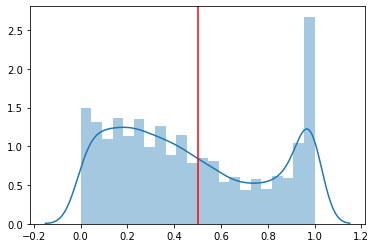

              precision    recall  f1-score   support

       False       1.00      0.69      0.82     12293
        True       0.35      1.00      0.52      2065

    accuracy                           0.73     14358
   macro avg       0.68      0.84      0.67     14358
weighted avg       0.91      0.73      0.77     14358



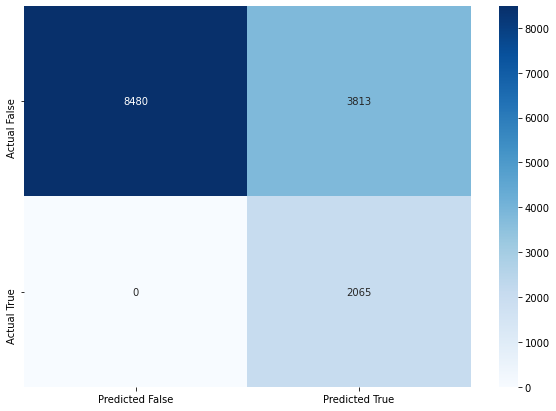

In [43]:
#OR IDENTIFY THE 2000 WATERPUMPS IN THE VALIDATION SET WITH THE HIGHEST PREDICTIED PROBABILITIES

def set_thres(y_val, y_pred_proba, thres=0.5):
  y_pred = y_pred_proba > thres 
  ax = sns.distplot(y_pred_proba)
  ax.axvline(thres, color='red') 
  plt.show()
  print(classification_report(y_val, y_pred))
  plot_cm(y_val, y_pred)

set_thres(y_pred, y_pred_proba)

In [44]:
from ipywidgets import interact, fixed

interact(set_thres, y_val=fixed(y_val), y_pred_proba=fixed(y_pred_proba), thres = (0,1,0.1))

interactive(children=(FloatSlider(value=0.5, description='thres', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.set_thres>